C:\Users\pbenko\AppData\Local\Temp\1\ipykernel_16988\71283951.py:21: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



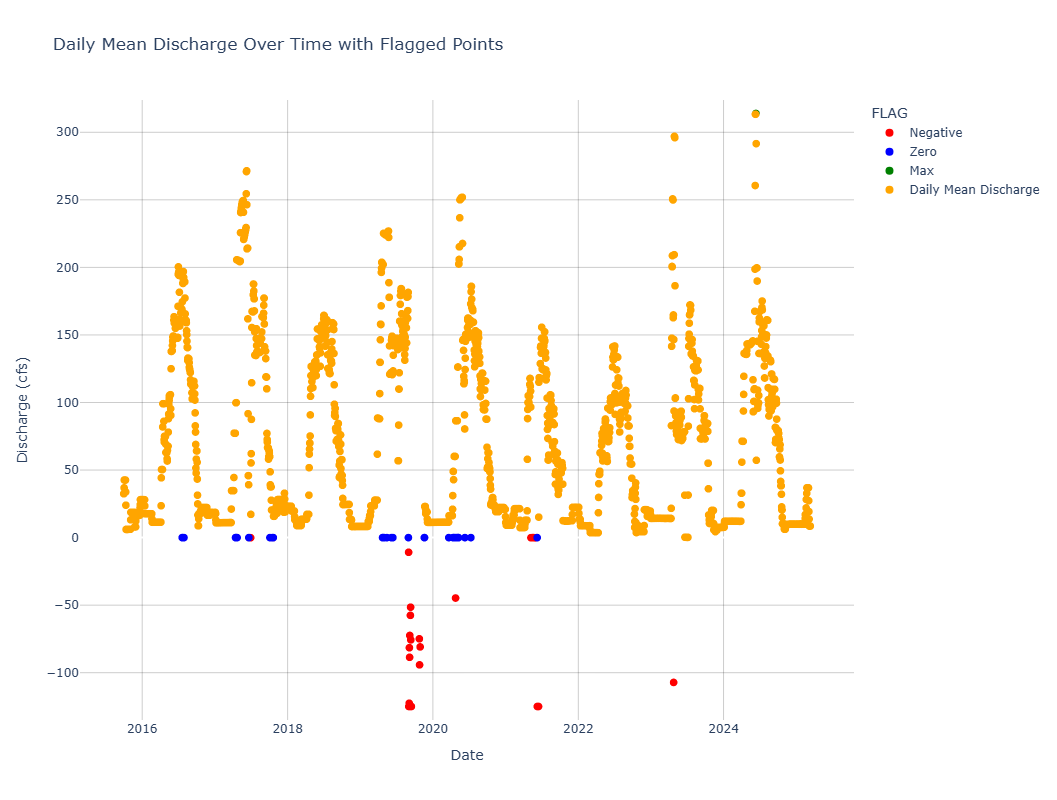

In [16]:
import pyodbc
import pandas as pd
import plotly.express as px
import numpy as np

# Database connection parameters
server = 'wrt-sql-prod'
database = 'dvrtDB'
username = 'wrtsqlq'
password = 'guest'

# Establish connection and fetch data
with pyodbc.connect(
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password}"
) as conn:
    query = "SELECT * FROM dbo.DAILY_RECORDS WHERE STATION_ID = 10987"
    df = pd.read_sql_query(query, conn)

# Reshape data: Convert wide format (RV_0101 to RV_1231) into long format
df_melted = df.melt(id_vars=['STATION_ID', 'RECORD_YEAR'], 
                    var_name='DAY', 
                    value_name='DISCHARGE')

# Extract and clean the DAY column (remove "RV_" and ensure 4-digit format)
df_melted['DAY'] = df_melted['DAY'].str[3:].str.zfill(4)

# Combine YEAR and DAY into a proper DATE column and handle invalid dates
df_melted['DATE'] = pd.to_datetime(
    df_melted['RECORD_YEAR'].astype(str) + df_melted['DAY'], 
    format='%Y%m%d', 
    errors='coerce'
)

# Force Discharge to Numeric
df_melted['DISCHARGE'] = pd.to_numeric(df_melted['DISCHARGE'], errors='coerce')

# Drop rows where DATE or DISCHARGE is NULL
df_melted = df_melted.dropna(subset=['DATE', 'DISCHARGE'])

# Calculate mean daily discharge
mean_discharge = df_melted['DISCHARGE'].mean()

df_melted['FLAG'] = np.select(
    [
        df_melted['DISCHARGE'] < 0,
        df_melted['DISCHARGE'] == 0,
        np.isclose(df_melted['DISCHARGE'], df_melted['DISCHARGE'].max()),
        np.isclose(df_melted['DISCHARGE'], df_melted['DISCHARGE'].min()),
        np.isclose(df_melted['DISCHARGE'], mean_discharge)
    ],
    ['Negative', 'Zero', 'Max', 'Min', 'Discharge'],
    default='Daily Mean Discharge'
)

# Plot with only markers for data points (no lines connecting missing data)
fig = px.scatter(
    df_melted, x='DATE', y='DISCHARGE', color='FLAG',
    title='Daily Mean Discharge Over Time with Flagged Points',
    labels={'DATE': 'Date', 'DISCHARGE': 'Discharge (cfs)'},
    color_discrete_map={
        'Negative': 'red',
        'Zero': 'blue',
        'Max': 'green',
        'Min': 'purple',
        'Daily Mean Discharge' : 'orange'
    },
    category_orders={'FLAG': ['Normal', 'Negative', 'Zero', 'Max', 'Min']}
)


# Ensure all data points are shown by adjusting marker size for visibility
fig.update_traces(marker=dict(size=8))  # Remove white circles, simple markers

# Update layout for better visualization and larger plot, ensuring the entire dataset is visible
fig.update_layout(
    hovermode='x unified',
    plot_bgcolor='white',
    xaxis=dict(gridcolor='rgba(0,0,0,0.2)'),
    yaxis=dict(
        gridcolor='rgba(0,0,0,0.2)',
        range=[df_melted['DISCHARGE'].min() - 10, df_melted['DISCHARGE'].max() + 10]  # Adjust y-axis to fit all data
    ),
    showlegend=True,
    width=1000,  # Adjust the width
    height=800   # Adjust the height
)

# Show the plot
fig.show()

In [7]:
import pyodbc
import pandas as pd

# Database connection parameters
server = 'wrt-sql-prod'
database = 'dvrtDB'
username = 'wrtsqlq'
password = 'guest'

# Establish connection and fetch data
with pyodbc.connect(
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password}"
) as conn:
    query = "SELECT * FROM dbo.DAILY_RECORDS WHERE STATION_ID = 10987"
    df = pd.read_sql_query(query, conn)

# Extract day columns dynamically
day_columns = [col for col in df.columns if col.startswith('RV_')]

# Create a list to hold processed rows
processed_rows = []

# Iterate over rows and day columns to build a structured DataFrame
for _, row in df.iterrows():
    year = row['RECORD_YEAR']
    for day_col in day_columns:
        day_str = day_col[3:]  # Extract day string like '0101'
        try:
            date = pd.to_datetime(f"{year}{day_str}", format='%Y%m%d')
            discharge = row[day_col]  # Keep original value, including NaN/NULL
            processed_rows.append({'DATE': date, 'DISCHARGE': discharge})
        except ValueError:
            processed_rows.append({'DATE': None, 'DISCHARGE': row[day_col]})  # Keep discharge even if date is invalid

# Create a new DataFrame
processed_df = pd.DataFrame(processed_rows)

# Export to CSV
processed_df.to_csv('daily_discharge_data.csv', index=False)

C:\Users\pbenko\AppData\Local\Temp\1\ipykernel_11268\546770562.py:19: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



C:\Users\pbenko\AppData\Local\Temp\1\ipykernel_11268\2707030019.py:21: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



Global Min Value Detected: -125.0
           DATE  DISCHARGE
1737 2019-09-02     -125.0
1738 2019-09-03     -125.0
1743 2019-09-08     -125.0
1744 2019-09-09     -125.0
1748 2019-09-13     -125.0
1749 2019-09-14     -125.0
1750 2019-09-15     -125.0
2395 2021-06-09     -125.0
2396 2021-06-10     -125.0
2397 2021-06-11     -125.0
2398 2021-06-12     -125.0
2399 2021-06-13     -125.0
2400 2021-06-14     -125.0
2401 2021-06-15     -125.0


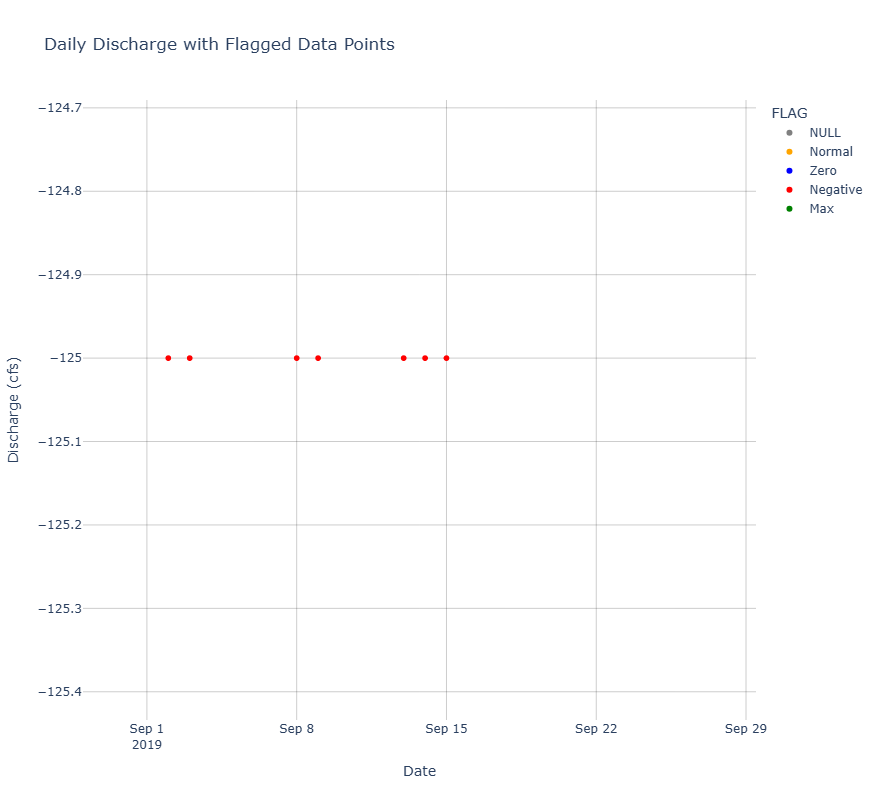

In [16]:
import pyodbc
import pandas as pd
import plotly.express as px
import numpy as np

# Database connection parameters
server = 'wrt-sql-prod'
database = 'dvrtDB'
username = 'wrtsqlq'
password = 'guest'

# Establish connection and fetch data
with pyodbc.connect(
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password}"
) as conn:
    query = "SELECT * FROM dbo.DAILY_RECORDS WHERE STATION_ID = 10987"
    df = pd.read_sql_query(query, conn)

# Extract day columns dynamically
day_columns = [col for col in df.columns if col.startswith('RV_')]

# Create a list to hold processed rows
processed_rows = []

# Iterate over rows and day columns to build a structured DataFrame
for _, row in df.iterrows():
    year = row['RECORD_YEAR']
    for day_col in day_columns:
        day_str = day_col[3:]  # Extract day string like '0101'
        try:
            date = pd.to_datetime(f"{year}{day_str}", format='%Y%m%d')
            discharge = row[day_col]  # Keep original value, including NaN/NULL
            processed_rows.append({'DATE': date, 'DISCHARGE': discharge})
        except ValueError:
            processed_rows.append({'DATE': None, 'DISCHARGE': row[day_col]})  # Keep discharge even if date is invalid

# Create a new DataFrame
processed_df = pd.DataFrame(processed_rows)

# Ensure DISCHARGE is numeric
processed_df['DISCHARGE'] = pd.to_numeric(processed_df['DISCHARGE'], errors='coerce')

# Drop rows where DISCHARGE or DATE is NaN for min/max calculation
valid_discharge = processed_df.dropna(subset=['DISCHARGE', 'DATE'])

# Calculate global min and max
min_val = valid_discharge['DISCHARGE'].min()
max_val = valid_discharge['DISCHARGE'].max()

# Check if min value exists in data
min_rows = valid_discharge[valid_discharge['DISCHARGE'] == min_val]
if not min_rows.empty:
    print(f"Global Min Value Detected: {min_val}")
    print(min_rows[['DATE', 'DISCHARGE']])
else:
    print("No Min Value Found in Data")

# Flagging criteria
def flag_discharge(value):
    if pd.isnull(value):
        return 'NULL'
    elif value < 0:
        return 'Negative'
    elif value == 0:
        return 'Zero'
    elif value == min_val:
        return 'Min'
    elif value == max_val:
        return 'Max'
    else:
        return 'Normal'

# Apply the flagging function
processed_df['FLAG'] = processed_df['DISCHARGE'].apply(flag_discharge)

# Filter data for plotting (exclude rows with null DATE)
plot_df = processed_df.dropna(subset=['DATE'])

# Create interactive plot
fig = px.scatter(
    plot_df, x='DATE', y='DISCHARGE', color='FLAG',
    title='Daily Discharge with Flagged Data Points',
    labels={'DATE': 'Date', 'DISCHARGE': 'Discharge (cfs)'},
    color_discrete_map={
        'NULL': 'gray',
        'Negative': 'red',
        'Zero': 'blue',
        'Min': 'purple',
        'Max': 'green',
        'Normal': 'orange'
    }
)

# Update layout for better visualization
fig.update_layout(
    hovermode='x unified',
    plot_bgcolor='white',
    xaxis=dict(gridcolor='rgba(0,0,0,0.2)'),
    yaxis=dict(gridcolor='rgba(0,0,0,0.2)'),
    showlegend=True,
    width=1000,
    height=800
)

# Show plot
fig.show()